# Random forest Rebb2020 detrimental

Here I train a prototype regressors with the provided features in a leave one protein out (lopo) fashion and I see the performances. I try with different feature compositions so to select the best features.

## Model
In this initial phase I use a random forest since it should work out of the box without extensive tuning. I just want a point of reference for features and performances.

## Cross validation
Initially I validated in a lopo approach by dataset, but this led to inflated performances since some proteins are present in more than 1 dataset. I opted to cross-validate by protein name (as a proxy of sequence identity) and then show the results by dataset. This means that, for BRCA2, I train a model on all the non-BRCA2 datasets and then show separately the predictions on the 3 BRCA2 datasets. This lead to more realistic performances in the BRCA2 and HSP90 datasets that before where showing inflated correlations.

## Features

I am using profiles, shannon entropy, pssm, mutation vector, substitution score. Profiles and shannon entropy are over a sliding window. The substitution score is calculated from the pssm by extracting the score for the observed substitution in the given position. I did not yet try different sliding window configurations. The inclusion of pssm and substitution score did not seem to have a strong effect.

## Psiblast database

The database used (swissprot or nr) seem to have a contradictory effect on different datasets. In general, however, swissprot seems to perform better and I will stick to it for the time being. The pseudocount used seems to have little effect. Note that for swissprot a pseudocount is needed when calculating shannon since some profile rows are 0, but for nr it can be omitted.

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut

norm_score = np.load('../processing/training_set/norm_score.npy')
dataset_vec = np.load('../processing/training_set/dataset_vec.npy').flatten()
mutation_vec = np.load('../processing/training_set/mutations_two_hot.npy')

# a vector of unique proteins, so that I do not have the same protein in training and testing
protein_vec = np.array([dataset.split('-')[0].split('_')[1] for dataset in list(dataset_vec)])

# reshape the vector so that it is 1d
y = norm_score.flatten()

# a general function that returns the indeces of a sliding window array of given size
def get_window_range(sliding_window_array):
    window_size = sliding_window_array.shape[1]
    upper = ((window_size - 1) // 2) + 1
    lower = - ((window_size - 1) // 2)
    return range(lower, upper)


def get_input_features(shannon_sliding_windows, profile_sliding_windows, pssm_sliding_windows, mutation_vec):
    
    # get the indeces for the sliding windows positions
    shannon_window_range = get_window_range(shannon_sliding_windows)
    profile_window_range = get_window_range(profile_sliding_windows)
    pssm_window_range = get_window_range(pssm_sliding_windows)
    
    # extract the pssm score for the current mutation
    # I am interested only in what I mutate to, what I come from is given by the position
    mutated_from_vec, mutated_to_vec = mutation_vec[:,:20], mutation_vec[:,20:]
    assert np.array_equal(np.concatenate([mutated_from_vec, mutated_to_vec], axis=1), mutation_vec)
     # I am interested only in the mutated position
    central_pssm_pos = pssm_window_range.index(0)
    central_pssm_vec = pssm_sliding_windows[:,central_pssm_pos,:] # slice along axis 1
    # I get only the pssm score for the current mutation in each position and I sum, since I do not care about where it is in the pssm array
    # since it is encoded already in the mutated to vector
    # I reshape to preserve the dimensionality
    substitution_score_vec = (central_pssm_vec * mutated_to_vec).sum(axis=1).reshape(-1,1)

    # create the input vector by concatenating the features and flattening them
    x = np.concatenate([shannon_sliding_windows.reshape(len(shannon_sliding_windows),-1),
                        profile_sliding_windows.reshape(len(profile_sliding_windows),-1),
                        pssm_sliding_windows.reshape(len(pssm_sliding_windows),-1),
                        mutation_vec,
                        substitution_score_vec,
                       ],
                       axis=1)

    # obtain a vector with the names of the features for easier recall
    x_features = np.array(['shannon_' + str(pos) for pos in shannon_window_range] +
                  ['profile_' + str(aa) + '_' + str(pos) for aa in range(20) for pos in profile_window_range] +
                  ['pssm_' + str(aa) + '_' + str(pos) for aa in range(20) for pos in pssm_window_range] +
                  ['mutation_' + kind + '_' + str(aa) for kind in ('from', 'to') for aa in range(20)] +
                  ['substitution_score'])
    
    return x, x_features

def lopo_plots_and_correlation(x, y, protein_vec=protein_vec, dataset_vec=dataset_vec):
    regr = RandomForestRegressor(n_jobs=-1, bootstrap=True, oob_score=False, n_estimators=100, verbose=0)
    lopo = LeaveOneGroupOut()
    max_spearman, min_spearman = -100, 100 # reversed since I want them to be updated
    max_pearson, min_pearson = -100, 100
    results = []
    for train_index, test_index in lopo.split(x, y, protein_vec):
        curr_protein_tested = list(set(protein_vec[test_index]))
        curr_dataset_vec = dataset_vec[test_index]
        assert len(curr_protein_tested) == 1
        print('Protein:', curr_protein_tested[0])
        y_train, y_test = y[train_index], y[test_index]
        x_train, x_test = x[train_index], x[test_index]
        regr.fit(x_train, y_train)
        y_pred = regr.predict(x_test)
        for dataset in list(set(curr_dataset_vec)):
            print('Dataset:', dataset)
            
            y_pred_to_show, y_test_to_show = y_pred[curr_dataset_vec == dataset], y_test[curr_dataset_vec == dataset]
            curr_spearman, curr_pearson = stats.spearmanr(y_pred_to_show, y_test_to_show)[0], stats.pearsonr(y_pred_to_show, y_test_to_show)[0]
            max_spearman, min_spearman = max(max_spearman, curr_spearman), min(min_spearman, curr_spearman)
            max_pearson, min_pearson = max(max_pearson, curr_pearson), min(min_pearson, curr_pearson)
            results.append([dataset, curr_spearman, curr_pearson, [y_pred_to_show, y_test_to_show]])
            
            print('spearman:', curr_spearman, '\npearson:', curr_pearson)
            
            plt.close()
            sns.scatterplot(x=y_pred_to_show, y=y_test_to_show, s=10)
            plt.show()
            
    print('Overall min spearman:', min_spearman, '\nOverall max spearman', max_spearman)
    print('Overall min pearson:', min_pearson, '\nOverall max pearson', max_pearson)
    result = pd.DataFrame(results, columns=['dataset', 'spearman', 'pearson', 'full_results'])
    
    return results

        
def oob_plots_and_correlation(x,y):
    regr = RandomForestRegressor(n_jobs=-1, bootstrap=True, oob_score=True, n_estimators=100, verbose=1)
    regr.fit(x, y)
    print('oob score', regr.oob_score_, '\nspearman', stats.spearmanr(regr.oob_prediction_, y)[0], '\npearson', stats.pearsonr(regr.oob_prediction_, y)[0])
    plt.close()
    sns.scatterplot(x=regr.oob_prediction_, y=y, s=1)
    plt.show()

In [2]:
shannon_sliding_windows = np.load('../processing/training_set/swissprot_db/shannon_10e-10_pseudocount_sliding_windows.npz')['arr_0']
profile_sliding_windows = np.load('../processing/training_set/swissprot_db/profiles_sliding_windows.npz')['arr_0']
pssm_sliding_windows = np.load('../processing/training_set/swissprot_db/pssm_sliding_windows.npz')['arr_0']
x, x_features = get_input_features(shannon_sliding_windows, profile_sliding_windows, pssm_sliding_windows, mutation_vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


oob score 0.4956524523501594 
spearman 0.6704677962566725 
pearson 0.706826353304242


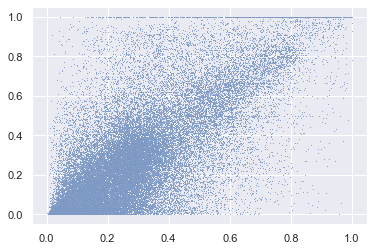

In [3]:
results = oob_plots_and_correlation(x, y)

Protein: BRCA1
Dataset: Findlay2018_BRCA1-BRCA1_2018_SCORE
spearman: 0.3950430203383059 
pearson: 0.4357486416994901


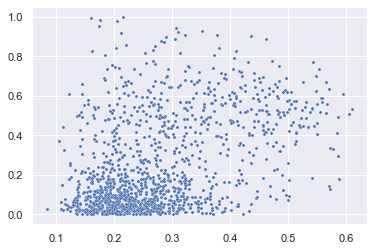

Dataset: Starita2015_BRCA1-BRCA1_2015_E3
spearman: 0.1235286111998469 
pearson: 0.1408946802462545


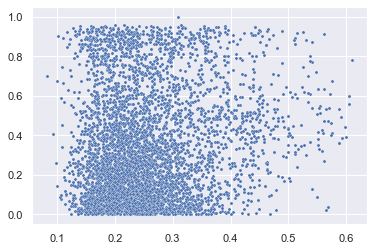

Dataset: Starita2015_BRCA1-BRCA1_2015_Y2H
spearman: 0.2534663073209083 
pearson: 0.3235959813655109


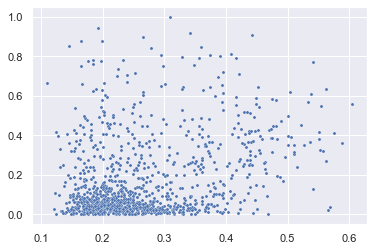

Protein: Bgl3
Dataset: Romero2015_Bgl3-Bgl3_SCORE
spearman: 0.4827590029605406 
pearson: 0.4715048992678184


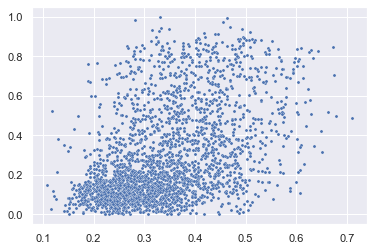

Protein: CCR5
Dataset: Heredia2018_CCR5-CCR5_2018_EXPR_R100
spearman: 0.2960567636226869 
pearson: 0.35636471151892246


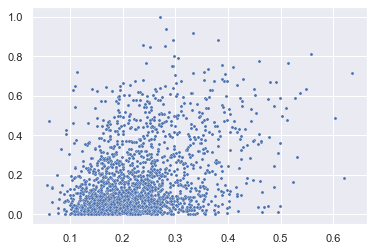

Protein: CXCR4
Dataset: Heredia2018_CXCR4-CXCR4_2018_EXPR_R100
spearman: 0.10408053490574905 
pearson: 0.19205443653926424


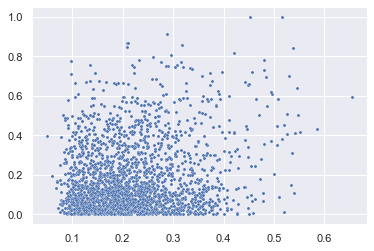

Protein: CcdB
Dataset: Adkar2012_CcdB-CCDB_2012_MSSEQ
spearman: 0.056623519395504494 
pearson: 0.04512174805989056


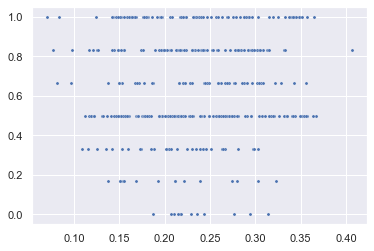

Protein: GFP
Dataset: Sarkisyan2016_GFP-GFP_2016_SCORE
spearman: 0.3328483011178451 
pearson: 0.37195472062479923


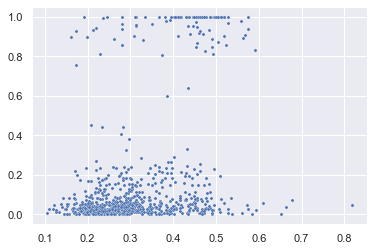

Protein: Gal4
Dataset: Kitzman2014_Gal4-GAL4_SCORE
spearman: 0.29275012641193177 
pearson: 0.280371410818726


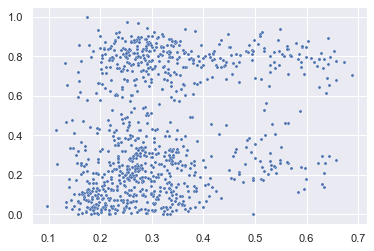

Protein: HSP90
Dataset: Jiang2013_HSP90-HSP90_2013_EXP
spearman: 0.32198327134053445 
pearson: 0.41575954465764997


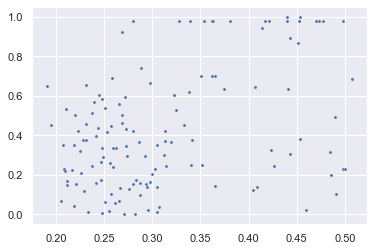

Dataset: Hietpas2011_HSP90-HSP90_2011_SCORE
spearman: 0.32517285831477794 
pearson: 0.34666445866134077


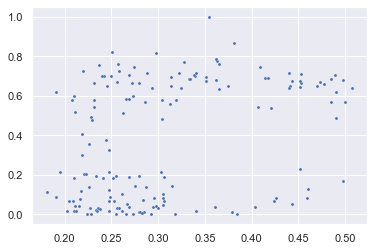

Dataset: Hietpas2013_HSP90-HSP90_2013_SCORE
spearman: 0.3329611882902302 
pearson: 0.4599375111987291


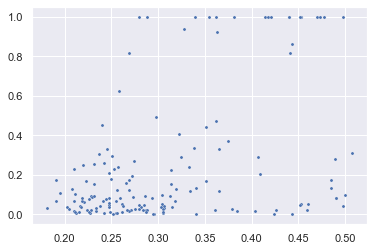

Protein: IgG1
Dataset: Traxlmayr2012_IgG1_CH3-IgG1_CH3_HCONF
spearman: 0.17161819823237587 
pearson: 0.16501163435962096


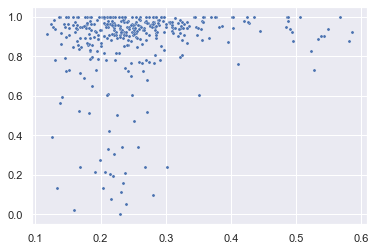

Protein: LGK
Dataset: Klesmith2015_LGK-LGK_2015_SCORE
spearman: 0.1640073805074358 
pearson: 0.15340333925150035


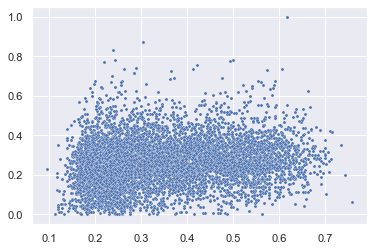

Protein: MAPK1
Dataset: Brenan2016_MAPK1-MAPK1_SCORE
spearman: 0.3153362940720279 
pearson: 0.31842760915690593


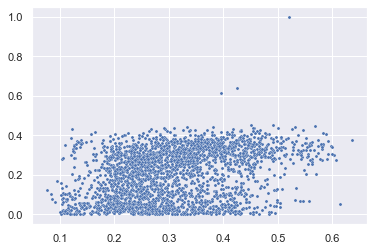

Protein: MTH3
Dataset: RockahShmuel2015_MTH3-MTH3_SCORE
spearman: 0.39663199555468265 
pearson: 0.40101716842754914


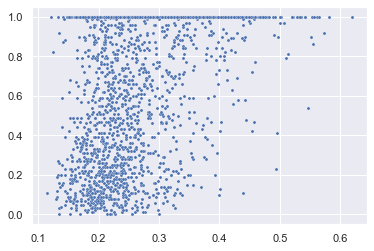

Protein: PPARG
Dataset: Majithia2016_PPARG-PPARG_SCORE
spearman: 0.32714528163575396 
pearson: 0.35328625184791856


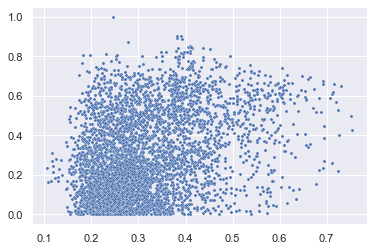

Protein: PTEN
Dataset: Matreyek2018_PTEN-PTEN_SCORE
spearman: 0.3504163932130845 
pearson: 0.3655800813024949


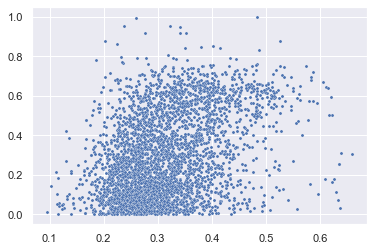

Protein: TEM1
Dataset: Stiffler2015_TEM1-TEM1_2015_SCORE
spearman: 0.5483264749462872 
pearson: 0.5445094455174896


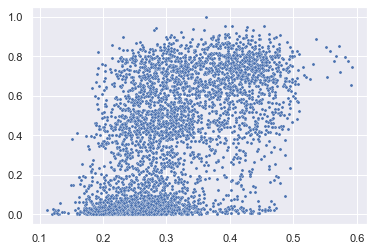

Protein: TPMT
Dataset: Matreyek2018_TPMT-TPMT_SCORE
spearman: 0.41689817305389176 
pearson: 0.42394238693546177


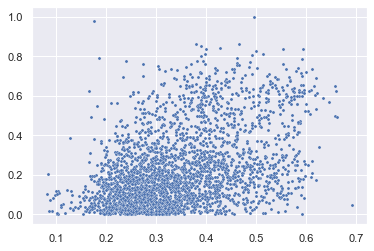

Protein: UBE4B
Dataset: Starita2013_UBE4B-UBE4B_SCORE
spearman: 0.36336658918211384 
pearson: 0.4168147507197463


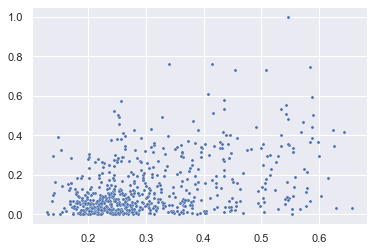

Protein: YAP1
Dataset: Araya2012_YAP1-YAP1_SCORE
spearman: 0.546004932650351 
pearson: 0.5211004709806414


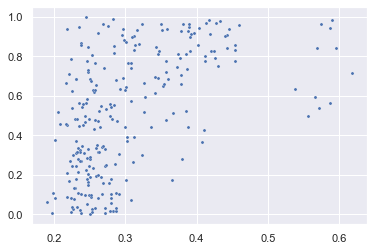

Overall min spearman: 0.056623519395504494 
Overall max spearman 0.5483264749462872
Overall min pearson: 0.04512174805989056 
Overall max pearson 0.5445094455174896


[['Findlay2018_BRCA1-BRCA1_2018_SCORE',
  0.3950430203383059,
  0.4357486416994901,
  [array([0.22456104, 0.28105632, 0.53380213, ..., 0.480177  , 0.23674845,
          0.49058672]),
   array([0.60268635, 0.54474   , 0.44012392, ..., 0.23224515, 0.0783043 ,
          0.12478564])]],
 ['Starita2015_BRCA1-BRCA1_2015_E3',
  0.1235286111998469,
  0.1408946802462545,
  [array([0.27875694, 0.29386031, 0.25970461, ..., 0.27361681, 0.23441387,
          0.25976673]),
   array([0.02142215, 0.41148487, 0.35288933, ..., 0.2920376 , 0.7460812 ,
          0.7159151 ])]],
 ['Starita2015_BRCA1-BRCA1_2015_Y2H',
  0.2534663073209083,
  0.3235959813655109,
  [array([0.27875694, 0.29386031, 0.25970461, ..., 0.3413844 , 0.39427466,
          0.37773711]),
   array([0.02122774, 0.41136795, 0.35276076, ..., 0.91645867, 0.09914783,
          0.3655225 ])]],
 ['Romero2015_Bgl3-Bgl3_SCORE',
  0.4827590029605406,
  0.4715048992678184,
  [array([0.23140149, 0.51232255, 0.18868403, ..., 0.2089572 , 0.18144571,
  

In [3]:
lopo_plots_and_correlation(x, y)